In [1]:
import cv2
import numpy as np
#import paho.mqtt.client as mqtt
import time
import matplotlib.pyplot as plt
import os
#os.listdir()
import math

In [37]:
"""START HERE"""
1,256,400
gauge_number = 35
file_type='jpg'
# name the calibration image of your gauge 'gauge-#.jpg', for example 'gauge-5.jpg'.  It's written this way so you can easily try multiple images
###min_angle, max_angle, min_value, max_value, units, x, y, r = calibrate_gauge(gauge_number, file_type)

#feed an image (or frame) to get the current value, based on the calibration, by default uses same image as calibration
image = cv2.imread('../Gauge/frames/Video1//frame%s.%s' % (gauge_number, file_type))
###val = get_current_value(img, min_angle, max_angle, min_value, max_value, x, y, r, gauge_number, file_type)
###print ("Current reading: %s %s" %(val, units))

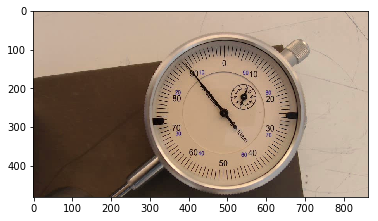

In [38]:
plt.imshow(image)

In [39]:
def avg_circles(circles, b):
    avg_x=0
    avg_y=0
    avg_r=0
    for i in range(b):
        #optional - average for multiple circles (can happen when a gauge is at a slight angle)
        avg_x = avg_x + circles[0][i][0]
        avg_y = avg_y + circles[0][i][1]
        avg_r = avg_r + circles[0][i][2]
    avg_x = int(avg_x/(b))
    avg_y = int(avg_y/(b))
    avg_r = int(avg_r/(b))
    return avg_x, avg_y, avg_r

In [40]:
def dist_2_pts(x1, y1, x2, y2):
    #print np.sqrt((x2-x1)^2+(y2-y1)^2)
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [44]:
#def calibrate_gauge(gauge_number, file_type):
#gauge_number=5
#file_type='jpg'
'''
    This function should be run using a test image in order to calibrate the range available to the dial as well as the
    units.  It works by first finding the center point and radius of the gauge.  Then it draws lines at hard coded intervals
    (separation) in degrees.  It then prompts the user to enter position in degrees of the lowest possible value of the gauge,
    as well as the starting value (which is probably zero in most cases but it won't assume that).  It will then ask for the
    position in degrees of the largest possible value of the gauge. Finally, it will ask for the units.  This assumes that
    the gauge is linear (as most probably are).
    It will return the min value with angle in degrees (as a tuple), the max value with angle in degrees (as a tuple),
    and the units (as a string).
'''

img = cv2.imread('../Gauge/frames/Video1/frame%s.%s' %(gauge_number, file_type))
height, width = img.shape[:2]
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #convert to gray
#gray = cv2.GaussianBlur(gray, (5, 5), 0)
#gray = cv2.medianBlur(gray, 5)

#for testing, output gray image
#cv2.imwrite('gauge-%s-bw.%s' %(gauge_number, file_type),gray)

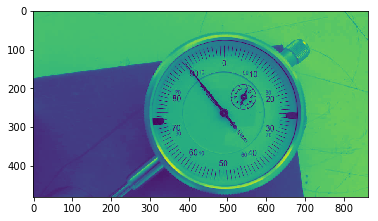

In [45]:
plt.imshow(gray)

In [46]:
#del circles
#detect circles
#restricting the search from 35-48% of the possible radii gives fairly good results across different samples.  Remember that
#these are pixel values which correspond to the possible radii search range.

circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 50, np.array([]), 80, 50, int(height*0.35), int(height*0.48))

#circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 80)

# average found circles, found it to be more accurate than trying to tune HoughCircles parameters to get just the right one

In [47]:
circles

array([[[494.5, 264.5, 187.4]]], dtype=float32)

Radius    187 494 264
187 187
gauge number: 35


"min_angle = 50 #raw_input('Min angle (lowest possible angle of dial) - in degrees: ') #the lowest possible angle\nmax_angle = 320 #raw_input('Max angle (highest possible angle) - in degrees: ') #highest possible angle\nmin_value = 0 #raw_input('Min value: ') #usually zero\nmax_value = 200 #raw_input('Max value: ') #maximum reading of the gauge\nunits = 'PSI' #raw_input('Enter units: ')"

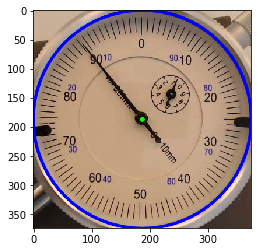

In [48]:
#del a, b, c,x,y,r

a, b, c = circles.shape
x,y,r = avg_circles(circles, b)
print("Radius   ", r, x, y)

#draw center and circle
cv2.circle(img, (x, y), r, (0, 0, 255), 3, cv2.LINE_AA)  # draw circle
cv2.circle(img, (x, y), 2, (0, 255, 0), 3, cv2.LINE_AA)  # draw center of circle


icircle=circles[0,:][0]
cropSize = (r*2, r*2)
nx=x-int(icircle[0]-cropSize[1]//2)
ny=y-int(icircle[1]-cropSize[0]//2)

print(nx,ny)


cropCoords = (max(0, icircle[1]-cropSize[0]//2),min(img.shape[0], icircle[1]+cropSize[0]//2),
                  max(0, icircle[0]-cropSize[1]//2),min(img.shape[1], icircle[0]+cropSize[1]//2)) 
crop_cimg = img[int(cropCoords[0]):int(cropCoords[1]),int(cropCoords[2]):int(cropCoords[3])] 

plt.imshow(crop_cimg)
#plt.imshow(crop_cimg)


#for testing, output circles on image
#cv2.imwrite('gauge-%s-circles.%s' % (gauge_number, file_type), img)


#for calibration, plot lines from center going out at every 10 degrees and add marker
#for i from 0 to 36 (every 10 deg)

'''
goes through the motion of a circle and sets x and y values based on the set separation spacing.  Also adds text to each
line.  These lines and text labels serve as the reference point for the user to enter
NOTE: by default this approach sets 0/360 to be the +x axis (if the image has a cartesian grid in the middle), the addition
(i+9) in the text offset rotates the labels by 90 degrees so 0/360 is at the bottom (-y in cartesian).  So this assumes the
gauge is aligned in the image, but it can be adjusted by changing the value of 9 to something else.
'''
separation = 10.0 #in degrees
interval = int(360 / separation)
p1 = np.zeros((interval,2))  #set empty arrays
p2 = np.zeros((interval,2))
p_text = np.zeros((interval,2))
for i in range(0,interval):
    for j in range(0,2):
        if (j%2==0):
            p1[i][j] = x + 0.9 * r * np.cos(separation * i * 3.14 / 180) #point for lines
        else:
            p1[i][j] = y + 0.9 * r * np.sin(separation * i * 3.14 / 180)
text_offset_x = 10
text_offset_y = 5
for i in range(0, interval):
    for j in range(0, 2):
        if (j % 2 == 0):
            p2[i][j] = x + r * np.cos(separation * i * 3.14 / 180)
            p_text[i][j] = x - text_offset_x + 1.2 * r * np.cos((separation) * (i+27) * 3.14 / 180) #point for text labels, i+9 rotates the labels by 90 degrees
        else:
            p2[i][j] = y + r * np.sin(separation * i * 3.14 / 180)
            p_text[i][j] = y + text_offset_y + 1.2* r * np.sin((separation) * (i+27) * 3.14 / 180)  # point for text labels, i+9 rotates the labels by 90 degrees

#add the lines and labels to the image
for i in range(0,interval):
    cv2.line(img, (int(p1[i][0]), int(p1[i][1])), (int(p2[i][0]), int(p2[i][1])),(0, 255, 0), 2)
    cv2.putText(img, '%s' %(int(i*separation)), (int(p_text[i][0]), int(p_text[i][1])), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(0,0,0),1,cv2.LINE_AA)

cv2.imwrite('../Gauge/processed/frame%s-calibration.%s' % (gauge_number, file_type), img)

#get user input on min, max, values, and units
print ('gauge number: %s' %gauge_number)
"""min_angle = 50 #raw_input('Min angle (lowest possible angle of dial) - in degrees: ') #the lowest possible angle
max_angle = 320 #raw_input('Max angle (highest possible angle) - in degrees: ') #highest possible angle
min_value = 0 #raw_input('Min value: ') #usually zero
max_value = 200 #raw_input('Max value: ') #maximum reading of the gauge
units = 'PSI' #raw_input('Enter units: ')"""

#for testing purposes: hardcode and comment out raw_inputs above
# min_angle = 45
# max_angle = 320
# min_value = 0
# max_value = 200
# units = "PSI"

#return min_angle, max_angle, min_value, max_value, units, x, y, r

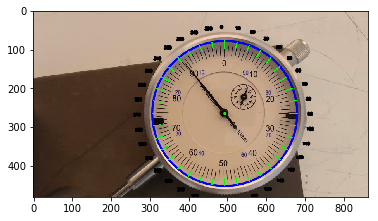

In [49]:
plt.imshow(img)

In [50]:
min_angle = 0 #raw_input('Min angle (lowest possible angle of dial) - in degrees: ') #the lowest possible angle
max_angle = 359 #raw_input('Max angle (highest possible angle) - in degrees: ') #highest possible angle
min_value = 0 #raw_input('Min value: ') #usually zero
max_value = 99 #raw_input('Max value: ') #maximum reading of the gauge
units = 'mm' #raw_input('Enter units: ')

In [51]:
#def get_current_value(img, min_angle, max_angle, min_value, max_value, x, y, r, gauge_number, file_type):

#for testing purposes
#img = cv2.imread('gauge-%s.%s' % (gauge_number, file_type))

gray2 = cv2.cvtColor(crop_cimg, cv2.COLOR_BGR2GRAY)


In [52]:

# Set threshold and maxValue
thresh = 175
maxValue = 255
fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()
# for testing purposes, found cv2.THRESH_BINARY_INV to perform the best
# th, dst1 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_BINARY);
# th, dst2 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_BINARY_INV);
# th, dst3 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_TRUNC);
# th, dst4 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_TOZERO);
# th, dst5 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_TOZERO_INV);
# cv2.imwrite('gauge-%s-dst1.%s' % (gauge_number, file_type), dst1)
# cv2.imwrite('gauge-%s-dst2.%s' % (gauge_number, file_type), dst2)
# cv2.imwrite('gauge-%s-dst3.%s' % (gauge_number, file_type), dst3)
# cv2.imwrite('gauge-%s-dst4.%s' % (gauge_number, file_type), dst4)
# cv2.imwrite('gauge-%s-dst5.%s' % (gauge_number, file_type), dst5)

# apply thresholding which helps for finding lines
(thresh, dst2) = cv2.threshold(gray2, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
# found Hough Lines generally performs better without Canny / blurring, though there were a couple exceptions where it would only work with Canny / blurring

gray = cv2.bitwise_not(gray2)
bw = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY, 15, -2)


dst2 = cv2.medianBlur(dst2, 5)
dst2 = cv2.GaussianBlur(dst2, (5, 5), 0)
dst2 = cv2.Canny(dst2, 50, 150)

fgmask = fgbg.apply(crop_cimg)

"""_, contours, _ = cv2.findContours(dst2, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
for i, c in enumerate(contours):
    # Calculate the area of each contour
    area = cv2.contourArea(c);
    # Ignore contours that are too small or too large
    if area < 1e2 or 1e5 < area:
        continue
    # Draw each contour only for visualisation purposes
    cv2.drawContours(dst2, contours, i, (0, 0, 255), 2);"""

# for testing, show image after thresholding
cv2.imwrite('../Gauge/processed/frame%s-tempdst1.%s' % (gauge_number, file_type), dst2)

# find lines


True

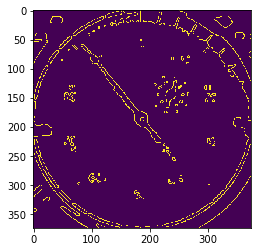

In [53]:
plt.imshow(dst2)

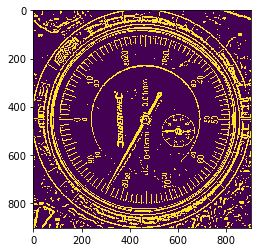

In [18]:
plt.imshow(bw)

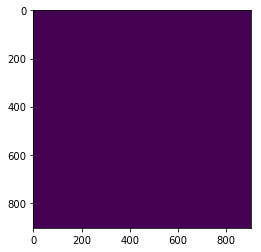

In [19]:
plt.imshow(fgmask)

In [54]:
minLineLength = 10
maxLineGap = 0
lines = cv2.HoughLinesP(image=dst2, rho=3, theta=np.pi / 180, threshold=100,minLineLength=minLineLength, maxLineGap=0)  # rho is set to 3 to detect more lines, easier to get more then filter them out later

#for testing purposes, show all found lines
"""for i in range(0, len(lines)):
    for x1, y1, x2, y2 in lines[i]:
        cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
cv2.imwrite('../Gauge/processed/frame%s-lines-test.%s' %(gauge_number, file_type), img)"""

"for i in range(0, len(lines)):\n    for x1, y1, x2, y2 in lines[i]:\n        cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)\ncv2.imwrite('../Gauge/processed/frame%s-lines-test.%s' %(gauge_number, file_type), img)"

In [55]:
lines.shape

(12, 1, 4)

In [56]:
# remove all lines outside a given radius
final_line_list = []
#print "radius: %s" %r
linelength=[]

diff1LowerBound = 0.15 #diff1LowerBound and diff1UpperBound determine how close the line should be from the center
diff1UpperBound = 0.25
diff2LowerBound = 0.5 #diff2LowerBound and diff2UpperBound determine how close the other point of the line should be to the outside of the gauge
diff2UpperBound = 1.0

print("length of lines %d"%len(lines))

for i in range(0, len(lines)):
    for x1, y1, x2, y2 in lines[i]:
        diff1 = dist_2_pts(nx, ny, x1, y1)  # x, y is center of circle
        diff2 = dist_2_pts(nx, ny, x2, y2)  # x, y is center of circle
        #set diff1 to be the smaller (closest to the center) of the two), makes the math easier
        if (diff1 > diff2):
            temp = diff1
            diff1 = diff2
            diff2 = temp
        # check if line is within an acceptable range
        #if (((diff1<diff1UpperBound*r) and (diff1>diff1LowerBound*r) and (diff2<diff2UpperBound*r)) and (diff2>diff2LowerBound*r)):
            line_length = dist_2_pts(nx, nx, x2, y2)
            linelength.append(line_length)
            # add to final list
            final_line_list.append([x1, y1, x2, y2])

lst=linelength.index(max(linelength))
            
#testing only, show all lines after filtering
#for i in range(0,len(final_line_list)):
#    x1 = final_line_list[i][0]
#    y1 = final_line_list[i][1]
#    x2 = final_line_list[i][2]
#    y2 = final_line_list[i][3]
#    cv2.line(crop_cimg, (nx, ny), (x2, y2), (0, 255, 0), 2)

# assumes the first line is the best one
if len(final_line_list)>0:
    x1 = final_line_list[lst][0]
    y1 = final_line_list[lst][1]
    x2 = final_line_list[lst][2]
    y2 = final_line_list[lst][3]
    #cv2.line(crop_cimg, (nx, ny), (x2, y2), (0, 255, 0), 2)  removed and added in below if condition

    #for testing purposes, show the line overlayed on the original image
    #cv2.imwrite('gauge-1-test.jpg', img)
    #cv2.imwrite('../Gauge/processed/frame%s-lines-2.%s' % (gauge_number, file_type), img) # FINAL IMAGE WRITE
    
    #find the farthest point from the center to be what is used to determine the angle
    dist_pt_0 = dist_2_pts(nx, ny, x1, y1)
    dist_pt_1 = dist_2_pts(nx, ny, x2, y2)
    if (dist_pt_0 > dist_pt_1):
        x_angle = x1 - nx
        y_angle = ny - y1
        cv2.line(crop_cimg, (nx, ny), (x1, y1), (0, 255, 0), 2)
        print("X1 Y1 NX NY",x1,y1, nx , ny)
    else:
        x_angle = x2 - nx
        y_angle = ny - y2
        cv2.line(crop_cimg, (nx, ny), (x2, y2), (0, 255, 0), 2)
        print("X2 Y2 NX NY",x2,y2, nx , ny)


    print("final line",final_line_list)    
    print("x_angle , y_angle",x_angle, y_angle)

    # take the arc tan of y/x to find the angle
    #res = np.arctan2(np.divide(float(y_angle), float(x_angle)))
    res = (np.divide(float(y_angle), float(x_angle)))

    #np.rad2deg(res) #coverts to degrees
    print("arctan angle is %f" % ((res)))
    # print x_angle
    # print y_angle
    # print res
    # print np.rad2deg(res)

    #these were determined by trial and error
    res = np.rad2deg(abs(res))

    print("degrees %d" % ((res)))

    if x_angle > 0 and y_angle > 0:  #in quadrant I
        final_angle = res
    if x_angle < 0 and y_angle > 0:  #in quadrant II
        final_angle = 270+res
    if x_angle < 0 and y_angle < 0:  #in quadrant III
        final_angle = 180+res
    if x_angle > 0 and y_angle < 0:  #in quadrant IV
        final_angle = 90+res

    print ("final_angle",final_angle)

    old_min = float(min_angle)
    old_max = float(max_angle)

    new_min = float(min_value)
    new_max = float(max_value)

    old_value = final_angle

    old_range = (old_max - old_min)
    new_range = (new_max - new_min)
    new_value = (((old_value - old_min) * new_range) / old_range) + new_min
    cv2.putText(img, str(new_value), (0, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), lineType=cv2.LINE_AA)
    cv2.imwrite('../Gauge/processed/frame%s-lines-2.%s' % (gauge_number, file_type), img)
    print(new_value)
    #return new_value

length of lines 12
X1 Y1 NX NY 31 22 187 187
final line [[120, 98, 145, 129], [144, 127, 161, 148], [160, 148, 180, 172], [147, 145, 156, 156], [31, 22, 47, 22], [55, 316, 65, 325], [315, 320, 325, 309]]
x_angle , y_angle -156 165
arctan angle is -1.057692
degrees 60
final_angle 330.6013052542217
91.1686050701057


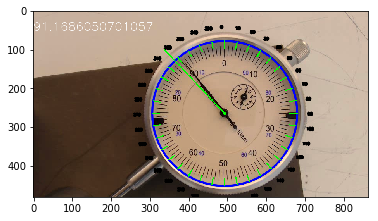

In [57]:
plt.imshow(img)

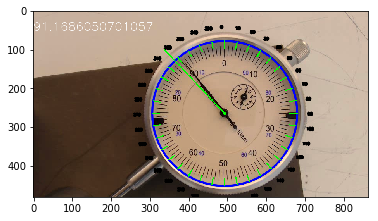

In [58]:
plt.imshow(img)

In [22]:
final_line_list[0]

[112, 243, 122, 234]

In [24]:
math.sqrt((final_line_list[0][0]-nx)**2+(final_line_list[0][1]-ny)**2)

94.57801012920498

In [25]:
np.sqrt((final_line_list[0][2]-nx)**2+(final_line_list[0][3]-ny)**2)

81.30190649671138

In [28]:
243+94

337

In [29]:
112-52

60

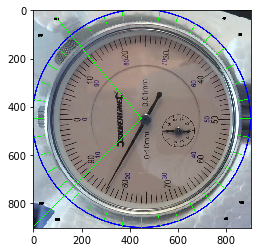

In [29]:
plt.imshow(crop_cimg)

In [38]:
cv2.line(crop_cimg,(nx,ny),(int(30),int(300)),(255,0,0),3)

array([[[200, 176, 152],
        [201, 177, 153],
        [201, 177, 153],
        ...,
        [212, 184, 160],
        [190, 160, 141],
        [179, 150, 135]],

       [[200, 176, 152],
        [201, 177, 153],
        [201, 177, 153],
        ...,
        [199, 168, 143],
        [187, 154, 134],
        [190, 157, 141]],

       [[200, 176, 152],
        [201, 177, 153],
        [201, 177, 153],
        ...,
        [193, 162, 137],
        [201, 170, 149],
        [194, 164, 145]],

       ...,

       [[ 32,  25,  22],
        [ 33,  27,  22],
        [ 33,  27,  22],
        ...,
        [ 70,  54,  47],
        [ 70,  54,  47],
        [ 70,  54,  47]],

       [[ 32,  25,  22],
        [ 33,  27,  22],
        [ 33,  27,  22],
        ...,
        [ 70,  54,  47],
        [ 70,  54,  47],
        [ 70,  54,  47]],

       [[ 34,  25,  22],
        [ 33,  27,  22],
        [ 33,  27,  22],
        ...,
        [ 70,  54,  47],
        [ 70,  54,  47],
        [ 70,  54,  47]]

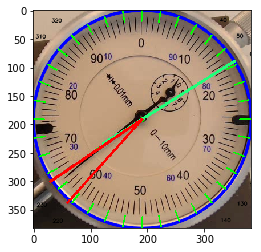

In [39]:
plt.imshow(crop_cimg)

In [46]:
math.sqrt((final_line_list[lst][2]-nx)**2+(final_line_list[lst][2]-ny)**2)

200.8183258569795

In [40]:
dX = 30 - 191
dY = 300 - 191
rads = math.atan2 (-dY, dX) #wrong for finding angle/declination?
math.degrees (rads)

-145.90126765303006

In [41]:
180-146

34

In [37]:
180+34

214

In [ ]:
numpy.linspace(p1[0], p2[0], parts+1), numpy.linspace(p1[1], p2[1], parts+1)

In [26]:
np.linspace(164, 191, 20+1)

array([164.  , 165.35, 166.7 , 168.05, 169.4 , 170.75, 172.1 , 173.45,
       174.8 , 176.15, 177.5 , 178.85, 180.2 , 181.55, 182.9 , 184.25,
       185.6 , 186.95, 188.3 , 189.65, 191.  ])

In [28]:
np.column_stack((np.linspace(164, 191, 20+1),np.linspace(154, 191, 20+1)))

array([[164.  , 154.  ],
       [165.35, 155.85],
       [166.7 , 157.7 ],
       [168.05, 159.55],
       [169.4 , 161.4 ],
       [170.75, 163.25],
       [172.1 , 165.1 ],
       [173.45, 166.95],
       [174.8 , 168.8 ],
       [176.15, 170.65],
       [177.5 , 172.5 ],
       [178.85, 174.35],
       [180.2 , 176.2 ],
       [181.55, 178.05],
       [182.9 , 179.9 ],
       [184.25, 181.75],
       [185.6 , 183.6 ],
       [186.95, 185.45],
       [188.3 , 187.3 ],
       [189.65, 189.15],
       [191.  , 191.  ]])

In [31]:
from sklearn.linear_model import LinearRegression

In [61]:
reg = LinearRegression(normalize=True)

In [37]:
X=(np.linspace(164, 191, 20+1))

In [39]:
y=np.linspace(154, 191, 20+1)

In [40]:
y

array([154.  , 155.85, 157.7 , 159.55, 161.4 , 163.25, 165.1 , 166.95,
       168.8 , 170.65, 172.5 , 174.35, 176.2 , 178.05, 179.9 , 181.75,
       183.6 , 185.45, 187.3 , 189.15, 191.  ])

In [38]:
X

array([164.  , 165.35, 166.7 , 168.05, 169.4 , 170.75, 172.1 , 173.45,
       174.8 , 176.15, 177.5 , 178.85, 180.2 , 181.55, 182.9 , 184.25,
       185.6 , 186.95, 188.3 , 189.65, 191.  ])

In [62]:
reg.fit(X.reshape(1, -1), y.reshape(1, -1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [57]:
newX=(np.linspace(100, 150, 20+1))

In [60]:
newX

array([100. , 102.5, 105. , 107.5, 110. , 112.5, 115. , 117.5, 120. ,
       122.5, 125. , 127.5, 130. , 132.5, 135. , 137.5, 140. , 142.5,
       145. , 147.5, 150. ])

In [63]:
yNew = reg.predict(newX.reshape(1, -1))

In [64]:
yNew

array([[154.  , 155.85, 157.7 , 159.55, 161.4 , 163.25, 165.1 , 166.95,
        168.8 , 170.65, 172.5 , 174.35, 176.2 , 178.05, 179.9 , 181.75,
        183.6 , 185.45, 187.3 , 189.15, 191.  ]])

In [56]:
y

array([154.  , 155.85, 157.7 , 159.55, 161.4 , 163.25, 165.1 , 166.95,
       168.8 , 170.65, 172.5 , 174.35, 176.2 , 178.05, 179.9 , 181.75,
       183.6 , 185.45, 187.3 , 189.15, 191.  ])

In [ ]:
#extending line


lenab = math.sqrt((200-232)**2+(158-146)**2)
length = 100
cx = 232 + (232-200) / lenab*length
cy = 146 + (146-158) / lenab*length
cv2.line(img,(200,158),(cx,cy),(33,322,122),3)
cv2.imshow('Tha',img)

353.0995197761209 89.9814586902435


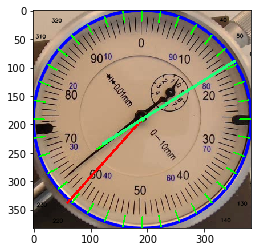

In [33]:
lenab = math.sqrt((x2-nx)**2+(y2-ny)**2)
length = 191
cx = nx + (nx-x2) / lenab*length
cy = ny + (ny-y2) / lenab*length

print(cx,cy)
cv2.line(crop_cimg,(x2,y2),(int(cx),int(cy)),(33,322,122),3)
plt.imshow(crop_cimg)

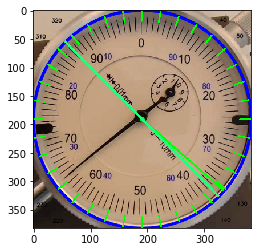

In [22]:
lenab = math.sqrt((x1-nx)**2+(y1-ny)**2)
length = 191
cx = nx + (nx-x1) / lenab*length
cy = ny + (ny-y1) / lenab*length
cv2.line(crop_cimg,(x1,y1),(int(cx),int(cy)),(33,322,122),3)
plt.imshow(crop_cimg)

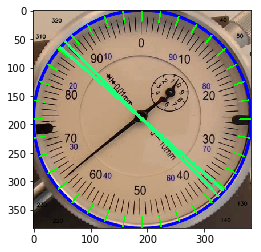

In [23]:
lenab = math.sqrt((x2-nx)**2+(y2-ny)**2)
length = 191
cx = nx + (nx-x2) / lenab*length
cy = ny + (ny-y2) / lenab*length
cv2.line(crop_cimg,(x2,y2),(int(cx),int(cy)),(33,322,122),3)
plt.imshow(crop_cimg)

In [3]:
import math

x1, y1 = 112,343
x2, y2 = 191,191
inner_product = x1*x2 + y1*y2
len1 = math.hypot(x1, y1)
len2 = math.hypot(x2, y2)
res= math.acos(inner_product/(len1*len2))
ang = res*180/math.pi
ang = ang * (-1)
print(ang)

-26.916554616951355


In [4]:
180+27

207

In [ ]:
195

In [ ]:
164 154 195 195

In [36]:
file_typef='jpg'
for gauge_numberf in range (1,700):
    frame = cv2.imread('../Gauge/frames/Video1/frame%s.%s' % (gauge_numberf, file_typef))
    grey = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    
    #**********1
    #edges=cv2.Canny(grey,50,150,apertureSize=5,L2gradient=True)
    #**********1

    #**********2
    #(thresh, dst2) = cv2.threshold(grey, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    #plt.imshow(dst2)
    #dst2 = cv2.medianBlur(dst2, 5)
    #dst = cv2.GaussianBlur(grey, (5, 5), 0)
    #dst2 = cv2.Canny(dst2, 50, 150)
    #**********2

    #**********3
    """gray = cv2.bitwise_not(grey)
    bw = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY, 15, -2)"""
    #**********3
    height, width = frame.shape[:2]
    minLineLength = 127
    maxLineGap = 0
    circles = cv2.HoughCircles(grey, cv2.HOUGH_GRADIENT, 1, 100)



    #*****************************************************************************************************
    a, b, c = circles.shape
    x,y,r = avg_circles(circles, b) 

    """x=344 #hard coding this for testing
    y=273
    r=127"""

    #draw center and circle
    cv2.circle(frame, (x, y), r, (0, 0, 255), 3, cv2.LINE_AA)  # draw circle
    cv2.circle(frame, (x, y), 2, (0, 255, 0), 3, cv2.LINE_AA)  # draw center of circle
    #plt.imshow(frame)
    cropSize = (r*2, r*2)

    icircle=circles[0,:][0]

    nx=x-int(icircle[0]-cropSize[1]//2)
    ny=y-int(icircle[1]-cropSize[0]//2)

    cropCoords = (max(0, icircle[1]-cropSize[0]//2),min(frame.shape[0], icircle[1]+cropSize[0]//2),
                  max(0, icircle[0]-cropSize[1]//2),min(frame.shape[1], icircle[0]+cropSize[1]//2)) 
    crop_cimg = frame[int(cropCoords[0]):int(cropCoords[1]),int(cropCoords[2]):int(cropCoords[3])]
    #plt.imshow(crop_cimg)
    #print(x,y,r)




    #for testing, output circles on image
    #cv2.imwrite('gauge-%s-circles.%s' % (gauge_number, file_type), img)


    #for calibration, plot lines from center going out at every 10 degrees and add marker
    #for i from 0 to 36 (every 10 deg)

    '''
    goes through the motion of a circle and sets x and y values based on the set separation spacing.  Also adds text to each
    line.  These lines and text labels serve as the reference point for the user to enter
    NOTE: by default this approach sets 0/360 to be the +x axis (if the image has a cartesian grid in the middle), the addition
    (i+9) in the text offset rotates the labels by 90 degrees so 0/360 is at the bottom (-y in cartesian).  So this assumes the
    gauge is aligned in the image, but it can be adjusted by changing the value of 9 to something else.
    '''
    separation = 10.0 #in degrees
    interval = int(360 / separation)
    p1 = np.zeros((interval,2))  #set empty arrays
    p2 = np.zeros((interval,2))
    p_text = np.zeros((interval,2))
    for i in range(0,interval):
        for j in range(0,2):
            if (j%2==0):
                p1[i][j] = x + 0.9 * r * np.cos(separation * i * 3.14 / 180) #point for lines
            else:
                p1[i][j] = y + 0.9 * r * np.sin(separation * i * 3.14 / 180)
    text_offset_x = 10
    text_offset_y = 5
    for i in range(0, interval):
        for j in range(0, 2):
            if (j % 2 == 0):
                p2[i][j] = x + r * np.cos(separation * i * 3.14 / 180)
                p_text[i][j] = x - text_offset_x + 1.2 * r * np.cos((separation) * (i+27) * 3.14 / 180) #point for text labels, i+9 rotates the labels by 90 degrees
            else:
                p2[i][j] = y + r * np.sin(separation * i * 3.14 / 180)
                p_text[i][j] = y + text_offset_y + 1.2* r * np.sin((separation) * (i+27) * 3.14 / 180)  # point for text labels, i+9 rotates the labels by 90 degrees

    #add the lines and labels to the image
    for i in range(0,interval):
        cv2.line(frame, (int(p1[i][0]), int(p1[i][1])), (int(p2[i][0]), int(p2[i][1])),(0, 255, 0), 2)
        cv2.putText(frame, '%s' %(int(i*separation)), (int(p_text[i][0]), int(p_text[i][1])), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(0,0,0),1,cv2.LINE_AA)    


    #*****************************************************************************************************
    min_angle = 0 #raw_input('Min angle (lowest possible angle of dial) - in degrees: ') #the lowest possible angle
    max_angle = 359 #raw_input('Max angle (highest possible angle) - in degrees: ') #highest possible angle
    min_value = 0 #raw_input('Min value: ') #usually zero
    max_value = 99 #raw_input('Max value: ') #maximum reading of the gauge
    units = 'mm' #raw_input('Enter units: ')
    thresh = 175
    maxValue = 255
    #plt.imshow(frame)
    #gray2 = cv2.cvtColor(crop_cimg, cv2.COLOR_BGR2GRAY)
    #plt.imshow(crop_cimg)
    #************1
    #gray = cv2.bitwise_not(grey)
    #bw = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY, 15, -2)
    #************1

    #************2
    (thresh, dst2) = cv2.threshold(grey, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    #************2

    #************3
    dst2 = cv2.medianBlur(dst2, 5)
    dst2 = cv2.GaussianBlur(dst2, (5, 5), 2)
    #dst2 = cv2.Canny(dst2, 50, 150)
    #************3

    #************4
    '''#dst2 = cv2.dilate(dst2, None, iterations=2)
    #cnts = cv2.findContours(dst2.copy(), cv2.RETR_EXTERNAL,
    #cv2.CHAIN_APPROX_SIMPLE)
    #cnts = imutils.grab_contours(cnts)'''
    #************4

    #************5
    fgmask = fgbg.apply(crop_cimg)
    #plt.imshow(fgmask)
    #plt.imshow(crop_cimg)
    #************5
    
    #************6
    fgmask = fgbg.apply(crop_cimg)
    dst3 = cv2.medianBlur(fgmask, 5)
    dst3 = cv2.GaussianBlur(dst3, (5, 5), 2)
    dst3 = cv2.Canny(dst3, 50, 150)
    #************6
    
    minLineLength = 30
    maxLineGap = 0
    #lines = cv2.HoughLinesP(image=gray2, rho=3, theta=np.pi / 180, threshold=100,minLineLength=minLineLength, maxLineGap=0)
    #lines = cv2.HoughLinesP(image=bw, rho=3, theta=np.pi / 180, threshold=100,minLineLength=minLineLength, maxLineGap=0)
    #lines = cv2.HoughLinesP(image=dst2, rho=3, theta=np.pi / 180, threshold=100,minLineLength=minLineLength, maxLineGap=0)
    lines = cv2.HoughLinesP(image=fgmask, rho=3, theta=np.pi / 180, threshold=100,minLineLength=minLineLength, maxLineGap=0)
    #print(lines[0])
    ##########################################################
    final_line_list = []
    #print "radius: %s" %r

    diff1LowerBound = 0.15 #diff1LowerBound and diff1UpperBound determine how close the line should be from the center
    diff1UpperBound = 0.25
    diff2LowerBound = 0.5 #diff2LowerBound and diff2UpperBound determine how close the other point of the line should be to the outside of the gauge
    diff2UpperBound = 1.0

    #print("length of lines %d"%len(lines))
    if lines is not None:
        for i in range(0, len(lines)):
            for x1, y1, x2, y2 in lines[i]:
                diff1 = dist_2_pts(nx, ny, x1, y1)  # x, y is center of circle
                diff2 = dist_2_pts(nx, ny, x2, y2)  # x, y is center of circle
                #set diff1 to be the smaller (closest to the center) of the two), makes the math easier
                if (diff1 > diff2):
                    temp = diff1
                    diff1 = diff2
                    diff2 = temp
                # check if line is within an acceptable range
                #if (((diff1<diff1UpperBound*r) and (diff1>diff1LowerBound*r) and (diff2<diff2UpperBound*r)) and (diff2>diff2LowerBound*r)):
                    line_length = dist_2_pts(x1, y1, x2, y2)
                    # add to final list
                    final_line_list.append([x1, y1, x2, y2])
                    #cv2.line(crop_cimg, (nx, ny), (x2, y2), (0, 255, 0), 2) #all lines
    if len(final_line_list)>0:
        x1 = final_line_list[0][0]
        y1 = final_line_list[0][1]
        x2 = final_line_list[0][2]
        y2 = final_line_list[0][3]
        
        ##########################################################
        #find the farthest point from the center to be what is used to determine the angle
        dist_pt_0 = dist_2_pts(nx, ny, x1, y1)
        dist_pt_1 = dist_2_pts(nx, ny, x2, y2)
        if (dist_pt_0 > dist_pt_1):
            x_angle = x1 - nx
            y_angle = ny - y1
            cv2.line(crop_cimg, (nx, ny), (x1, y1), (0, 255, 0), 2) #only 1 line
        else:
            x_angle = x2 - nx
            y_angle = ny - y2
            cv2.line(crop_cimg, (nx, ny), (x2, y2), (0, 255, 0), 2) #only 1 line

        print("final line",final_line_list[0])    
        print("x_angle , y_angle",x_angle, y_angle)

        # take the arc tan of y/x to find the angle
        #res = np.arctan2(np.divide(float(y_angle), float(x_angle)))
        res = (np.divide(float(y_angle), float(x_angle)))

        #np.rad2deg(res) #coverts to degrees
        print("arctan angle is %f" % ((res)))
        # print x_angle
        # print y_angle
        # print res
        # print np.rad2deg(res)

        #these were determined by trial and error
        res = np.rad2deg(abs(res))

        print("degrees %d" % ((res)))

        if x_angle > 0 and y_angle > 0:  #in quadrant I
            final_angle = res
        if x_angle < 0 and y_angle > 0:  #in quadrant II
            final_angle = 270+res
        if x_angle < 0 and y_angle < 0:  #in quadrant III
            final_angle = 180+res
        if x_angle > 0 and y_angle < 0:  #in quadrant IV
            final_angle = 90+res

        #print final_angle

        old_min = float(min_angle)
        old_max = float(max_angle)

        new_min = float(min_value)
        new_max = float(max_value)

        old_value = final_angle

        old_range = (old_max - old_min)
        new_range = (new_max - new_min)
        new_value = (((old_value - old_min) * new_range) / old_range) + new_min

        #print(new_value)
        #cv2.putText(frame, new_value, (int(r/2 - 20),int(r/2)), cv2.FONT_HERSHEY_DUPLEX, 3, (255, 0, 0),2)
        cv2.putText(frame, str(new_value), (0, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), lineType=cv2.LINE_AA)
        cv2.putText(frame, str(str(x_angle) +"  "+ str(y_angle)), (0, 80), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), lineType=cv2.LINE_AA)
        cv2.putText(frame, str(final_angle), (0, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), lineType=cv2.LINE_AA)
        cv2.imwrite('../Gauge/processed/VideoFunction/frame%s-lines.%s' % (gauge_numberf, 'jpg'), frame)

final line [138, 94, 162, 133]
x_angle , y_angle -49 93
arctan angle is -1.897959
degrees 108
final line [122, 81, 183, 175]
x_angle , y_angle -64 105
arctan angle is -1.640625
degrees 94
final line [145, 123, 170, 160]
x_angle , y_angle -41 63
arctan angle is -1.536585
degrees 88
final line [80, 77, 128, 124]
x_angle , y_angle -108 111
arctan angle is -1.027778
degrees 58
final line [119, 126, 158, 166]
x_angle , y_angle -69 62
arctan angle is -0.898551
degrees 51
final line [79, 87, 136, 146]
x_angle , y_angle -109 101
arctan angle is -0.926606
degrees 53
final line [94, 110, 130, 138]
x_angle , y_angle -93 77
arctan angle is -0.827957
degrees 47
final line [50, 100, 103, 132]
x_angle , y_angle -138 88
arctan angle is -0.637681
degrees 36
final line [85, 128, 125, 153]
x_angle , y_angle -103 60
arctan angle is -0.582524
degrees 33
final line [49, 105, 113, 145]
x_angle , y_angle -139 83
arctan angle is -0.597122
degrees 34
final line [45, 105, 101, 139]
x_angle , y_angle -143 83
arct

error: OpenCV(4.1.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


# Rotating Images

In [1]:
import cv2
import numpy as np
#import paho.mqtt.client as mqtt
import time
import matplotlib.pyplot as plt
import os
#os.listdir()
import math
import imutils

In [2]:
"""START HERE"""
1,256,400
gauge_number = 35
file_type='jpg'

image = cv2.imread('../Gauge/frames/Straight_Offset_notMoving/frame%s.%s' % (gauge_number, file_type))


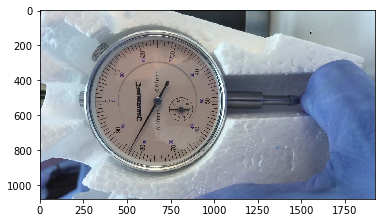

In [3]:
plt.imshow(image)

In [4]:
def avg_circles(circles, b):
    avg_x=0
    avg_y=0
    avg_r=0
    for i in range(b):
        #optional - average for multiple circles (can happen when a gauge is at a slight angle)
        avg_x = avg_x + circles[0][i][0]
        avg_y = avg_y + circles[0][i][1]
        avg_r = avg_r + circles[0][i][2]
    avg_x = int(avg_x/(b))
    avg_y = int(avg_y/(b))
    avg_r = int(avg_r/(b))
    return avg_x, avg_y, avg_r

In [5]:
def dist_2_pts(x1, y1, x2, y2):
    #print np.sqrt((x2-x1)^2+(y2-y1)^2)
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [6]:
img = cv2.imread('../Gauge/frames/Straight_Offset_notMoving/frame%s.%s' % (gauge_number, file_type))
height, width = img.shape[:2]
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #convert to gray

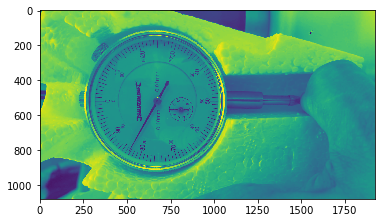

In [7]:
plt.imshow(gray)

In [9]:
"""# load the image from disk
#image = cv2.imread(args["image"])
 
# loop over the rotation angles
for angle in np.arange(0, 360, 15):
    rotated = imutils.rotate(img, angle)
    plt.imshow( rotated)
    cv2.waitKey(0)
 """

'# load the image from disk\n#image = cv2.imread(args["image"])\n \n# loop over the rotation angles\nfor angle in np.arange(0, 360, 15):\n    rotated = imutils.rotate(img, angle)\n    plt.imshow( rotated)\n    cv2.waitKey(0)\n '

In [10]:
"""rotated = imutils.rotate(img, 270)
plt.imshow( rotated)"""

'rotated = imutils.rotate(img, 270)\nplt.imshow( rotated)'

In [11]:
"""# loop over the rotation angles again, this time ensuring
# no part of the image is cut off
for angle in np.arange(0, 360, 15):
    rotated = imutils.rotate_bound(img, angle)
    plt.imshow("Rotated (Correct)", rotated)
    cv2.waitKey(0)"""

'# loop over the rotation angles again, this time ensuring\n# no part of the image is cut off\nfor angle in np.arange(0, 360, 15):\n    rotated = imutils.rotate_bound(img, angle)\n    plt.imshow("Rotated (Correct)", rotated)\n    cv2.waitKey(0)'

In [12]:
#circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 80)

circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 50, np.array([]), 80, 50, int(height*0.35), int(height*0.48))

In [13]:
#circles

In [14]:
#del a, b, c,x,y,r

a, b, c = circles.shape
x,y,r = avg_circles(circles, b)
print("Radius   ", r, x, y)

Radius    452 655 515


449 449


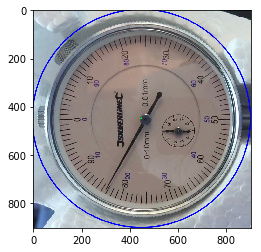

In [15]:
#draw center and circle
cv2.circle(img, (x, y), r, (0, 0, 255), 3, cv2.LINE_AA)  # draw circle
cv2.circle(img, (x, y), 2, (0, 255, 0), 3, cv2.LINE_AA)  # draw center of circle


icircle=circles[0,:][0]
cropSize = (r*2, r*2)
nx=x-int(icircle[0]-cropSize[1]//2)
ny=y-int(icircle[1]-cropSize[0]//2)

print(nx,ny)


cropCoords = (max(0, icircle[1]-cropSize[0]//2),min(img.shape[0], icircle[1]+cropSize[0]//2),
                  max(0, icircle[0]-cropSize[1]//2),min(img.shape[1], icircle[0]+cropSize[1]//2)) 
crop_cimg = img[int(cropCoords[0]):int(cropCoords[1]),int(cropCoords[2]):int(cropCoords[3])] 

plt.imshow(crop_cimg)
#plt.imshow(crop_cimg)


gauge number: 35


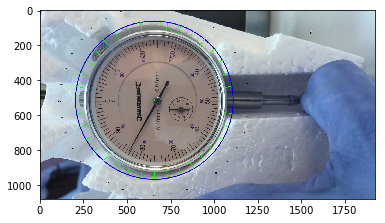

In [18]:
#for testing, output circles on image
#cv2.imwrite('gauge-%s-circles.%s' % (gauge_number, file_type), img)


#for calibration, plot lines from center going out at every 10 degrees and add marker
#for i from 0 to 36 (every 10 deg)

'''
goes through the motion of a circle and sets x and y values based on the set separation spacing.  Also adds text to each
line.  These lines and text labels serve as the reference point for the user to enter
NOTE: by default this approach sets 0/360 to be the +x axis (if the image has a cartesian grid in the middle), the addition
(i+9) in the text offset rotates the labels by 90 degrees so 0/360 is at the bottom (-y in cartesian).  So this assumes the
gauge is aligned in the image, but it can be adjusted by changing the value of 9 to something else.
'''
separation = 10.0 #in degrees
interval = int(360 / separation)
p1 = np.zeros((interval,2))  #set empty arrays
p2 = np.zeros((interval,2))
p_text = np.zeros((interval,2))
for i in range(0,interval):
    for j in range(0,2):
        if (j%2==0):
            p1[i][j] = x + 0.9 * r * np.cos(separation * i * 3.14 / 180) #point for lines
        else:
            p1[i][j] = y + 0.9 * r * np.sin(separation * i * 3.14 / 180)
text_offset_x = 10
text_offset_y = 5
for i in range(0, interval):
    for j in range(0, 2):
        if (j % 2 == 0):
            p2[i][j] = x + r * np.cos(separation * i * 3.14 / 180)
            p_text[i][j] = x - text_offset_x + 1.2 * r * np.cos((separation) * (i+27) * 3.14 / 180) #point for text labels, i+9 rotates the labels by 90 degrees
        else:
            p2[i][j] = y + r * np.sin(separation * i * 3.14 / 180)
            p_text[i][j] = y + text_offset_y + 1.2* r * np.sin((separation) * (i+27) * 3.14 / 180)  # point for text labels, i+9 rotates the labels by 90 degrees

#add the lines and labels to the image
for i in range(0,interval):
    cv2.line(img, (int(p1[i][0]), int(p1[i][1])), (int(p2[i][0]), int(p2[i][1])),(0, 255, 0), 2)
    cv2.putText(img, '%s' %(int(i*separation)), (int(p_text[i][0]), int(p_text[i][1])), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(0,0,0),1,cv2.LINE_AA)

cv2.imwrite('../Gauge/processed/frame%s-calibration.%s' % (gauge_number, file_type), img)

#get user input on min, max, values, and units
print ('gauge number: %s' %gauge_number)
"""min_angle = 50 #raw_input('Min angle (lowest possible angle of dial) - in degrees: ') #the lowest possible angle
max_angle = 320 #raw_input('Max angle (highest possible angle) - in degrees: ') #highest possible angle
min_value = 0 #raw_input('Min value: ') #usually zero
max_value = 200 #raw_input('Max value: ') #maximum reading of the gauge
units = 'PSI' #raw_input('Enter units: ')"""
plt.imshow(img)

#for testing purposes: hardcode and comment out raw_inputs above
# min_angle = 45
# max_angle = 320
# min_value = 0
# max_value = 200
# units = "PSI"

#return min_angle, max_angle, min_value, max_value, units, x, y, r

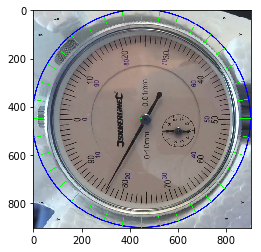

In [19]:
cropCoords = (max(0, icircle[1]-cropSize[0]//2),min(img.shape[0], icircle[1]+cropSize[0]//2),
                  max(0, icircle[0]-cropSize[1]//2),min(img.shape[1], icircle[0]+cropSize[1]//2)) 
crop_cimg = img[int(cropCoords[0]):int(cropCoords[1]),int(cropCoords[2]):int(cropCoords[3])] 

plt.imshow(crop_cimg)

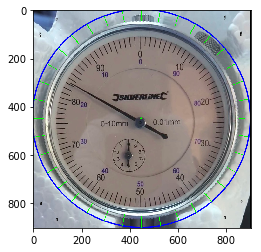

In [20]:
(h, w) = crop_cimg.shape[:2]
M = cv2.getRotationMatrix2D((nx,ny), 270, 1.0)
crop_cimg = cv2.warpAffine(crop_cimg, M, (h, w))
plt.imshow(crop_cimg)

In [21]:
min_angle = 0 #raw_input('Min angle (lowest possible angle of dial) - in degrees: ') #the lowest possible angle
max_angle = 360 #raw_input('Max angle (highest possible angle) - in degrees: ') #highest possible angle
min_value = 0 #raw_input('Min value: ') #usually zero
max_value = 100 #raw_input('Max value: ') #maximum reading of the gauge
units = 'mm' #raw_input('Enter units: ')

In [22]:
gray2 = cv2.cvtColor(crop_cimg, cv2.COLOR_BGR2GRAY)

In [23]:

# Set threshold and maxValue
thresh = 175
maxValue = 255
fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()
# for testing purposes, found cv2.THRESH_BINARY_INV to perform the best
# th, dst1 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_BINARY);
# th, dst2 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_BINARY_INV);
# th, dst3 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_TRUNC);
# th, dst4 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_TOZERO);
# th, dst5 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_TOZERO_INV);
# cv2.imwrite('gauge-%s-dst1.%s' % (gauge_number, file_type), dst1)
# cv2.imwrite('gauge-%s-dst2.%s' % (gauge_number, file_type), dst2)
# cv2.imwrite('gauge-%s-dst3.%s' % (gauge_number, file_type), dst3)
# cv2.imwrite('gauge-%s-dst4.%s' % (gauge_number, file_type), dst4)
# cv2.imwrite('gauge-%s-dst5.%s' % (gauge_number, file_type), dst5)

# apply thresholding which helps for finding lines
(thresh, dst2) = cv2.threshold(gray2, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
# found Hough Lines generally performs better without Canny / blurring, though there were a couple exceptions where it would only work with Canny / blurring

gray = cv2.bitwise_not(gray2)
bw = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY, 15, -2)


dst2 = cv2.medianBlur(dst2, 5)
dst2 = cv2.GaussianBlur(dst2, (5, 5), 0)
dst2 = cv2.Canny(dst2, 50, 150)

fgmask = fgbg.apply(crop_cimg)

"""_, contours, _ = cv2.findContours(dst2, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
for i, c in enumerate(contours):
    # Calculate the area of each contour
    area = cv2.contourArea(c);
    # Ignore contours that are too small or too large
    if area < 1e2 or 1e5 < area:
        continue
    # Draw each contour only for visualisation purposes
    cv2.drawContours(dst2, contours, i, (0, 0, 255), 2);"""

# for testing, show image after thresholding
cv2.imwrite('../Gauge/processed/frame%s-tempdst1.%s' % (gauge_number, file_type), dst2)

# find lines


True

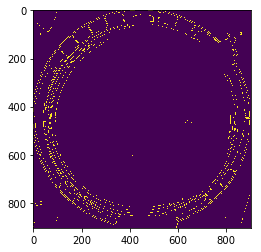

In [24]:
plt.imshow(dst2)

In [25]:
minLineLength = 10
maxLineGap = 0
lines = cv2.HoughLinesP(image=dst2, rho=3, theta=np.pi / 180, threshold=100,minLineLength=minLineLength, maxLineGap=0)  # rho is set to 3 to detect more lines, easier to get more then filter them out later

#for testing purposes, show all found lines
"""for i in range(0, len(lines)):
    for x1, y1, x2, y2 in lines[i]:
        cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
cv2.imwrite('../Gauge/processed/frame%s-lines-test.%s' %(gauge_number, file_type), img)"""

"for i in range(0, len(lines)):\n    for x1, y1, x2, y2 in lines[i]:\n        cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)\ncv2.imwrite('../Gauge/processed/frame%s-lines-test.%s' %(gauge_number, file_type), img)"

In [26]:
# remove all lines outside a given radius
final_line_list = []
#print "radius: %s" %r
linelength=[]

diff1LowerBound = 0.15 #diff1LowerBound and diff1UpperBound determine how close the line should be from the center
diff1UpperBound = 0.25
diff2LowerBound = 0.5 #diff2LowerBound and diff2UpperBound determine how close the other point of the line should be to the outside of the gauge
diff2UpperBound = 1.0

print("length of lines %d"%len(lines))

for i in range(0, len(lines)):
    for x1, y1, x2, y2 in lines[i]:
        diff1 = dist_2_pts(nx, ny, x1, y1)  # x, y is center of circle
        diff2 = dist_2_pts(nx, ny, x2, y2)  # x, y is center of circle
        #set diff1 to be the smaller (closest to the center) of the two), makes the math easier
        if (diff1 > diff2):
            temp = diff1
            diff1 = diff2
            diff2 = temp
        # check if line is within an acceptable range
        #if (((diff1<diff1UpperBound*r) and (diff1>diff1LowerBound*r) and (diff2<diff2UpperBound*r)) and (diff2>diff2LowerBound*r)):
            line_length = dist_2_pts(nx, nx, x2, y2)
            linelength.append(line_length)
            # add to final list
            final_line_list.append([x1, y1, x2, y2])

lst=linelength.index(max(linelength))
            
#testing only, show all lines after filtering
#for i in range(0,len(final_line_list)):
#    x1 = final_line_list[i][0]
#    y1 = final_line_list[i][1]
#    x2 = final_line_list[i][2]
#    y2 = final_line_list[i][3]
#    cv2.line(crop_cimg, (nx, ny), (x2, y2), (0, 255, 0), 2)

# assumes the first line is the best one
if len(final_line_list)>0:
    x1 = final_line_list[lst][0]
    y1 = final_line_list[lst][1]
    x2 = final_line_list[lst][2]
    y2 = final_line_list[lst][3]
    #cv2.line(crop_cimg, (nx, ny), (x2, y2), (0, 255, 0), 2)  removed and added in below if condition

    #for testing purposes, show the line overlayed on the original image
    #cv2.imwrite('gauge-1-test.jpg', img)
    #cv2.imwrite('../Gauge/processed/frame%s-lines-2.%s' % (gauge_number, file_type), img) # FINAL IMAGE WRITE
    
    #find the farthest point from the center to be what is used to determine the angle
    dist_pt_0 = dist_2_pts(nx, ny, x1, y1)
    dist_pt_1 = dist_2_pts(nx, ny, x2, y2)
    if (dist_pt_0 > dist_pt_1):
        x_angle = x1 - nx
        y_angle = ny - y1
        cv2.line(crop_cimg, (nx, ny), (x1, y1), (0, 255, 0), 2)
        print("X1 Y1 NX NY",x1,y1, nx , ny)
    else:
        x_angle = x2 - nx
        y_angle = ny - y2
        cv2.line(crop_cimg, (nx, ny), (x2, y2), (0, 255, 0), 2)
        print("X2 Y2 NX NY",x2,y2, nx , ny)


    print("final line",final_line_list)    
    print("x_angle , y_angle",x_angle, y_angle)

    # take the arc tan of y/x to find the angle
    #res = np.arctan2(np.divide(float(y_angle), float(x_angle)))
    res = (np.divide(float(y_angle), float(x_angle)))

    #np.rad2deg(res) #coverts to degrees
    print("arctan angle is %f" % ((res)))
    # print x_angle
    # print y_angle
    # print res
    # print np.rad2deg(res)

    #these were determined by trial and error
    res = np.rad2deg(abs(res))

    print("degrees %d" % ((res)))

    if x_angle > 0 and y_angle > 0:  #in quadrant I
        final_angle = res
    if x_angle < 0 and y_angle > 0:  #in quadrant II
        final_angle = 270+res
    if x_angle < 0 and y_angle < 0:  #in quadrant III
        final_angle = 180+res
    if x_angle > 0 and y_angle < 0:  #in quadrant IV
        final_angle = 90+res

    print ("final_angle",final_angle)

    old_min = float(min_angle)
    old_max = float(max_angle)

    new_min = float(min_value)
    new_max = float(max_value)

    old_value = final_angle

    old_range = (old_max - old_min)
    new_range = (new_max - new_min)
    new_value = (((old_value - old_min) * new_range) / old_range) + new_min
    cv2.putText(img, str(new_value), (0, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), lineType=cv2.LINE_AA)
    cv2.imwrite('../Gauge/processed/frame%s-lines-2.%s' % (gauge_number, file_type), img)
    print(new_value)
    #return new_value

length of lines 109
X1 Y1 NX NY 898 768 449 449
final line [[898, 768, 898, 539], [162, 208, 203, 167], [142, 245, 151, 235], [64, 504, 65, 494], [166, 208, 194, 180], [71, 463, 71, 453], [151, 710, 166, 725], [75, 483, 75, 469], [153, 230, 167, 215], [466, 816, 479, 815], [107, 275, 114, 263], [84, 617, 92, 633], [818, 470, 818, 459], [204, 771, 224, 785], [113, 678, 121, 688], [66, 464, 66, 450], [147, 196, 189, 154], [62, 459, 63, 446], [165, 741, 184, 758], [822, 467, 822, 445], [153, 713, 173, 733], [420, 816, 430, 816], [339, 802, 351, 805], [140, 224, 151, 210], [160, 215, 173, 202], [864, 325, 866, 335], [182, 198, 208, 174], [427, 830, 451, 830], [76, 427, 76, 442], [238, 132, 256, 121], [836, 518, 837, 505], [229, 151, 248, 138], [250, 146, 260, 140], [171, 239, 181, 227], [816, 493, 816, 483], [651, 48, 661, 54], [817, 481, 817, 471], [870, 352, 872, 363], [416, 853, 440, 853], [135, 661, 143, 671], [666, 782, 680, 771], [390, 839, 400, 839], [814, 630, 815, 620], [834, 576,

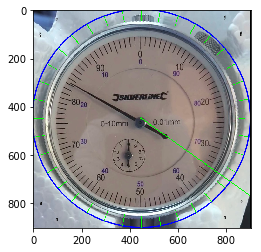

In [28]:
plt.imshow(crop_cimg)

In [2]:
import cv2
import numpy as np
#import paho.mqtt.client as mqtt
import time
import matplotlib.pyplot as plt
import os

In [3]:
def avg_circles(circles, b):
    avg_x=0
    avg_y=0
    avg_r=0
    for i in range(b):
        #optional - average for multiple circles (can happen when a gauge is at a slight angle)
        avg_x = avg_x + circles[0][i][0]
        avg_y = avg_y + circles[0][i][1]
        avg_r = avg_r + circles[0][i][2]
    avg_x = int(avg_x/(b))
    avg_y = int(avg_y/(b))
    avg_r = int(avg_r/(b))
    return avg_x, avg_y, avg_r

In [4]:
def dist_2_pts(x1, y1, x2, y2):
    #print np.sqrt((x2-x1)^2+(y2-y1)^2)
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [10]:
def calibrate_gauge(gauge_number, file_type):
    '''
        This function should be run using a test image in order to calibrate the range available to the dial as well as the
        units.  It works by first finding the center point and radius of the gauge.  Then it draws lines at hard coded intervals
        (separation) in degrees.  It then prompts the user to enter position in degrees of the lowest possible value of the gauge,
        as well as the starting value (which is probably zero in most cases but it won't assume that).  It will then ask for the
        position in degrees of the largest possible value of the gauge. Finally, it will ask for the units.  This assumes that
        the gauge is linear (as most probably are).
        It will return the min value with angle in degrees (as a tuple), the max value with angle in degrees (as a tuple),
        and the units (as a string).
    '''
    
    img = cv2.imread('../Gauge/frames/Video1/frame%s.%s' %(gauge_number, file_type))
    height, width = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #convert to gray
    #gray = cv2.GaussianBlur(gray, (5, 5), 0)
    # gray = cv2.medianBlur(gray, 5)

    #for testing, output gray image
    #cv2.imwrite('gauge-%s-bw.%s' %(gauge_number, file_type),gray)

    #detect circles
    #restricting the search from 35-48% of the possible radii gives fairly good results across different samples.  Remember that
    #these are pixel values which correspond to the possible radii search range.
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 100)
    # average found circles, found it to be more accurate than trying to tune HoughCircles parameters to get just the right one
    a, b, c = circles.shape
    x,y,r = avg_circles(circles, b)

    #draw center and circle
    cv2.circle(img, (x, y), r, (0, 0, 255), 3, cv2.LINE_AA)  # draw circle
    cv2.circle(img, (x, y), 2, (0, 255, 0), 3, cv2.LINE_AA)  # draw center of circle
    
    
    
    icircle=circles[0,:][0]
    cropSize = (r*2, r*2)
    nx=x-int(icircle[0]-cropSize[1]//2)
    ny=y-int(icircle[1]-cropSize[0]//2)
    
    print(nx,ny)
    
    
    cropCoords = (max(0, icircle[1]-cropSize[0]//2),min(img.shape[0], icircle[1]+cropSize[0]//2),
                      max(0, icircle[0]-cropSize[1]//2),min(img.shape[1], icircle[0]+cropSize[1]//2)) 
    crop_cimg = img[int(cropCoords[0]):int(cropCoords[1]),int(cropCoords[2]):int(cropCoords[3])] 
    
    
    
    #for testing, output circles on image
    #cv2.imwrite('gauge-%s-circles.%s' % (gauge_number, file_type), img)


    #for calibration, plot lines from center going out at every 10 degrees and add marker
    #for i from 0 to 36 (every 10 deg)

    '''
    goes through the motion of a circle and sets x and y values based on the set separation spacing.  Also adds text to each
    line.  These lines and text labels serve as the reference point for the user to enter
    NOTE: by default this approach sets 0/360 to be the +x axis (if the image has a cartesian grid in the middle), the addition
    (i+9) in the text offset rotates the labels by 90 degrees so 0/360 is at the bottom (-y in cartesian).  So this assumes the
    gauge is aligned in the image, but it can be adjusted by changing the value of 9 to something else.
    '''
    separation = 10.0 #in degrees
    interval = int(360 / separation)
    p1 = np.zeros((interval,2))  #set empty arrays
    p2 = np.zeros((interval,2))
    p_text = np.zeros((interval,2))
    for i in range(0,interval):
        for j in range(0,2):
            if (j%2==0):
                p1[i][j] = x + 0.9 * r * np.cos(separation * i * 3.14 / 180) #point for lines
            else:
                p1[i][j] = y + 0.9 * r * np.sin(separation * i * 3.14 / 180)
    text_offset_x = 10
    text_offset_y = 5
    for i in range(0, interval):
        for j in range(0, 2):
            if (j % 2 == 0):
                p2[i][j] = x + r * np.cos(separation * i * 3.14 / 180)
                p_text[i][j] = x - text_offset_x + 1.2 * r * np.cos((separation) * (i+27) * 3.14 / 180) #point for text labels, i+9 rotates the labels by 90 degrees
            else:
                p2[i][j] = y + r * np.sin(separation * i * 3.14 / 180)
                p_text[i][j] = y + text_offset_y + 1.2* r * np.sin((separation) * (i+27) * 3.14 / 180)  # point for text labels, i+9 rotates the labels by 90 degrees

    #add the lines and labels to the image
    for i in range(0,interval):
        cv2.line(img, (int(p1[i][0]), int(p1[i][1])), (int(p2[i][0]), int(p2[i][1])),(0, 255, 0), 2)
        cv2.putText(img, '%s' %(int(i*separation)), (int(p_text[i][0]), int(p_text[i][1])), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(0,0,0),1,cv2.LINE_AA)

    #cv2.imwrite('../Gauge/processed/funcframe%s-calibration.%s' % (gauge_number, file_type), img)
    cv2.imwrite('../Gauge/processed/funcframe%s-cropimages.%s' % (gauge_number, file_type), crop_cimg)
    #get user input on min, max, values, and units
    print ('gauge number: %s' %gauge_number)
    min_angle = 0 #raw_input('Min angle (lowest possible angle of dial) - in degrees: ') #the lowest possible angle
    max_angle = 359 #raw_input('Max angle (highest possible angle) - in degrees: ') #highest possible angle
    min_value = 0 #raw_input('Min value: ') #usually zero
    max_value = 99 #raw_input('Max value: ') #maximum reading of the gauge
    units = "mm" #raw_input('Enter units: ')

    #for testing purposes: hardcode and comment out raw_inputs above
    # min_angle = 45
    # max_angle = 320
    # min_value = 0
    # max_value = 200
    # units = "PSI"

    return min_angle, max_angle, min_value, max_value, units, nx, ny, r

In [37]:
def get_current_value(img, min_angle, max_angle, min_value, max_value, x, y, r, gauge_number, file_type):

    #for testing purposes
    #img = cv2.imread('gauge-%s.%s' % (gauge_number, file_type))
    new_value=0
    gray2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()
    # Set threshold and maxValue
    thresh = 175
    maxValue = 255

    # for testing purposes, found cv2.THRESH_BINARY_INV to perform the best
    # th, dst1 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_BINARY);
    # th, dst2 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_BINARY_INV);
    # th, dst3 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_TRUNC);
    # th, dst4 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_TOZERO);
    # th, dst5 = cv2.threshold(gray2, thresh, maxValue, cv2.THRESH_TOZERO_INV);
    # cv2.imwrite('gauge-%s-dst1.%s' % (gauge_number, file_type), dst1)
    # cv2.imwrite('gauge-%s-dst2.%s' % (gauge_number, file_type), dst2)
    # cv2.imwrite('gauge-%s-dst3.%s' % (gauge_number, file_type), dst3)
    # cv2.imwrite('gauge-%s-dst4.%s' % (gauge_number, file_type), dst4)
    # cv2.imwrite('gauge-%s-dst5.%s' % (gauge_number, file_type), dst5)

    # apply thresholding which helps for finding lines
    (th, dst2) = cv2.threshold(gray2, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    
    gray = cv2.bitwise_not(gray2)
    bw = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY, 15, -2)
    
    # found Hough Lines generally performs better without Canny / blurring, though there were a couple exceptions where it would only work with Canny / blurring
    dst2 = cv2.medianBlur(dst2, 5)
    dst2 = cv2.GaussianBlur(dst2, (5, 5), 0)
    dst2 = cv2.Canny(dst2, 50, 150)
    
    print("PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE")
    # for testing, show image after thresholding
    cv2.imwrite('../Gauge/processed/funcframe%s-tempdst1.%s' % (gauge_number, file_type), dst2)
    
    fgmask = fgbg.apply(crop_cimg)
    
    # find lines
    minLineLength = 10
    maxLineGap = 0
    lines = cv2.HoughLinesP(image=dst2, rho=3, theta=np.pi / 180, threshold=100,minLineLength=minLineLength, maxLineGap=0)  # rho is set to 3 to detect more lines, easier to get more then filter them out later

    #for testing purposes, show all found lines
    """for i in range(0, len(lines)):
        for x1, y1, x2, y2 in lines[i]:
            cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.imwrite('../Gauge/processed/funcframe%s-lines-test.%s' %(gauge_number, file_type), img)"""
    cv2.imwrite('../Gauge/processed/funcframe%s-lines-test.%s' %(gauge_number, file_type), img)
    # remove all lines outside a given radius
    final_line_list = []
    #print "radius: %s" %r
    print(final_line_list)
    diff1LowerBound = 0.15 #diff1LowerBound and diff1UpperBound determine how close the line should be from the center
    diff1UpperBound = 0.25
    diff2LowerBound = 0.5 #diff2LowerBound and diff2UpperBound determine how close the other point of the line should be to the outside of the gauge
    diff2UpperBound = 1.0
    
    #print("length of lines %d"%len(lines))
    if lines is not None:
        for i in range(0, len(lines)):
            for x1, y1, x2, y2 in lines[i]:
                diff1 = dist_2_pts(x, y, x1, y1)  # x, y is center of circle
                diff2 = dist_2_pts(x, y, x2, y2)  # x, y is center of circle
                #set diff1 to be the smaller (closest to the center) of the two), makes the math easier
                if (diff1 > diff2):
                    temp = diff1
                    diff1 = diff2
                    diff2 = temp
                # check if line is within an acceptable range
                #print("acceptable range is diff1 %d d1ub %d d1lb %d diff2 %d d2ub %d d2lb %d" %(diff1, (diff1UpperBound*r), (diff1LowerBound*r), diff2, (diff2UpperBound*r), (diff2LowerBound*r)))
                #if (((diff1<diff1UpperBound*r) and (diff1>diff1LowerBound*r) and (diff2<diff2UpperBound*r)) and (diff2>diff2LowerBound*r)):
                    print ("this line in lines[] is perfect one %d" % i)

                    line_length = dist_2_pts(x1, y1, x2, y2)
                    # add to final list
                    final_line_list.append([x1, y1, x2, y2])

    #testing only, show all lines after filtering
    # for i in range(0,len(final_line_list)):
    #     x1 = final_line_list[i][0]
    #     y1 = final_line_list[i][1]
    #     x2 = final_line_list[i][2]
    #     y2 = final_line_list[i][3]
    #     cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # assumes the first line is the best one
    if(len(final_line_list)>0):
        x1 = final_line_list[0][0]
        y1 = final_line_list[0][1]
        x2 = final_line_list[0][2]
        y2 = final_line_list[0][3]
        cv2.line(img, (x, y), (x2, y2), (0, 255, 0), 2)
        #cv2.putText(img, str(new_value), (0, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 0), lineType=cv2.LINE_AA)
        cv2.imwrite('../Gauge/processed/frame%s-lines-1.%s' % (gauge_number, file_type), img)

        #find the farthest point from the center to be what is used to determine the angle
        dist_pt_0 = dist_2_pts(x, y, x1, y1)
        dist_pt_1 = dist_2_pts(x, y, x2, y2)
        if (dist_pt_0 > dist_pt_1):
            x_angle = x1 - x
            y_angle = y - y1
        else:
            x_angle = x2 - x
            y_angle = y - y2
        # take the arc tan of y/x to find the angle
        res = np.arctan(np.divide(float(y_angle), float(x_angle)))
        #np.rad2deg(res) #coverts to degrees

        # print x_angle
        # print y_angle
        # print res
        # print np.rad2deg(res)

        #these were determined by trial and error
        res = np.rad2deg(res)
        if x_angle > 0 and y_angle > 0:  #in quadrant I
            final_angle = 270 - res
        if x_angle < 0 and y_angle > 0:  #in quadrant II
            final_angle = 90 - res
        if x_angle < 0 and y_angle < 0:  #in quadrant III
            final_angle = 90 - res
        if x_angle > 0 and y_angle < 0:  #in quadrant IV
            final_angle = 270 - res

        #print final_angle

        old_min = float(min_angle)
        old_max = float(max_angle)

        new_min = float(min_value)
        new_max = float(max_value)

        old_value = final_angle

        old_range = (old_max - old_min)
        new_range = (new_max - new_min)
        new_value = (((old_value - old_min) * new_range) / old_range) + new_min
        #cv2.putText(img, str(new_value), (0, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 0), lineType=cv2.LINE_AA)
        #cv2.imwrite('../Gauge/processed/Video1/frame%s-lines-1.%s' % (gauge_number, file_type), img)
        
    else:
        print("line within an acceptable range was not found")
    #for testing purposes, show the line overlayed on the original image
    #cv2.imwrite('gauge-1-test.jpg', img)
    """cv2.imwrite('../Gauge/processed/frame%s-lines-1.%s' % (gauge_number, file_type), img)

    #find the farthest point from the center to be what is used to determine the angle
    dist_pt_0 = dist_2_pts(x, y, x1, y1)
    dist_pt_1 = dist_2_pts(x, y, x2, y2)
    if (dist_pt_0 > dist_pt_1):
        x_angle = x1 - x
        y_angle = y - y1
    else:
        x_angle = x2 - x
        y_angle = y - y2
    # take the arc tan of y/x to find the angle
    res = np.arctan(np.divide(float(y_angle), float(x_angle)))
    #np.rad2deg(res) #coverts to degrees

    # print x_angle
    # print y_angle
    # print res
    # print np.rad2deg(res)

    #these were determined by trial and error
    res = np.rad2deg(res)
    if x_angle > 0 and y_angle > 0:  #in quadrant I
        final_angle = 270 - res
    if x_angle < 0 and y_angle > 0:  #in quadrant II
        final_angle = 90 - res
    if x_angle < 0 and y_angle < 0:  #in quadrant III
        final_angle = 90 - res
    if x_angle > 0 and y_angle < 0:  #in quadrant IV
        final_angle = 270 - res

    #print final_angle

    old_min = float(min_angle)
    old_max = float(max_angle)

    new_min = float(min_value)
    new_max = float(max_value)

    old_value = final_angle

    old_range = (old_max - old_min)
    new_range = (new_max - new_min)
    new_value = (((old_value - old_min) * new_range) / old_range) + new_min"""

    return new_value

In [38]:
#gauge_numberf = 300
for gauge_numberf in range (1,700):
    try:
        file_typef='jpg'
        # name the calibration image of your gauge 'gauge-#.jpg', for example 'gauge-5.jpg'.  It's written this way so you can easily try multiple images
        min_anglef, max_anglef, min_valuef, max_valuef, unitsf, xf, yf, rf = calibrate_gauge(gauge_numberf, file_typef)
        print("min_angle - %d, max_angle - %d, min_value - %d, max_value - %d, units - %s, x - %d, y - %d, r - %d" % (min_anglef, max_anglef, min_valuef, max_valuef, unitsf, xf, yf, rf))
        #feed an image (or frame) to get the current value, based on the calibration, by default uses same image as calibration
        fimg = cv2.imread('../Gauge/processed/funcframe%s-cropimages.%s' % (gauge_numberf, file_type))
        fimg2 = cv2.imread('../Gauge/frames/Video1/frame%s.%s' % (gauge_numberf, file_typef))
        #plt.imshow(fimg)
        value = get_current_value(fimg, min_anglef, max_anglef, min_valuef, max_valuef, xf, yf, rf, gauge_numberf, file_typef)
        print ("Current reading: %s %s" %(value, unitsf))
    except:
        pass

195 195
gauge number: 1
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 195, y - 195, r - 195
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 5
this line in lines[] is perfect one 6
this line in lines[] is perfect one 8
this line in lines[] is perfect one 9
this line in lines[] is perfect one 10
this line in lines[] is perfect one 13
this line in lines[] is perfect one 15
Current reading: 46.5902667252371 mm
192 192
gauge number: 2
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 192, y - 192, r - 192
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 4
this line in lines[] is perfect one 5
this line in lines[] is perf

PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 5
this line in lines[] is perfect one 8
this line in lines[] is perfect one 11
this line in lines[] is perfect one 13
Current reading: 44.27698203902663 mm
209 209
gauge number: 16
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 209, y - 209, r - 209
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 4
this line in lines[] is perfect one 5
this line in lines[] is perfect one 6
this line in lines[] is perfect one 7
this line in lines[] is perfect one 9
this line in lines[] is perfect one 13
this line in lines[] is perfect one 1

196 196
gauge number: 30
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 196, y - 196, r - 196
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 8
Current reading: 40.26565308118326 mm
187 187
gauge number: 31
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 187, y - 187, r - 187
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 6
this line in lines[] is perfect one 7
this line in lines[] is perfect one 9
this line in lines[] is perfect one 10
this line in lines[] is perfect one 15
Current reading: 40.02761609957235 mm
188 188
gauge number: 32
min_angle - 0, max_angle - 359, min_val

188 188
gauge number: 47
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 188, y - 188, r - 188
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 4
this line in lines[] is perfect one 6
this line in lines[] is perfect one 7
this line in lines[] is perfect one 8
this line in lines[] is perfect one 13
this line in lines[] is perfect one 14
this line in lines[] is perfect one 15
Current reading: 36.30005680869206 mm
188 188
gauge number: 48
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 188, y - 188, r - 188
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is p

195 195
gauge number: 60
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 195, y - 195, r - 195
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 4
this line in lines[] is perfect one 5
this line in lines[] is perfect one 6
this line in lines[] is perfect one 8
this line in lines[] is perfect one 10
this line in lines[] is perfect one 12
this line in lines[] is perfect one 13
this line in lines[] is perfect one 17
this line in lines[] is perfect one 18
this line in lines[] is perfect one 20
Current reading: 35.54547302030105 mm
187 187
gauge number: 61
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 187, y - 187, r - 187
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] i

Current reading: 34.274096993715006 mm
196 196
gauge number: 75
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 196, y - 196, r - 196
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 3
this line in lines[] is perfect one 4
this line in lines[] is perfect one 5
this line in lines[] is perfect one 8
this line in lines[] is perfect one 9
this line in lines[] is perfect one 10
this line in lines[] is perfect one 12
this line in lines[] is perfect one 13
this line in lines[] is perfect one 14
this line in lines[] is perfect one 17
this line in lines[] is perfect one 18
this line in lines[] is perfect one 20
Current reading: 34.54587666688368 mm
192 192
gauge number: 76
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 192, y - 192, r - 192
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[]

187 187
gauge number: 90
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 187, y - 187, r - 187
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 3
this line in lines[] is perfect one 4
this line in lines[] is perfect one 5
this line in lines[] is perfect one 6
this line in lines[] is perfect one 8
this line in lines[] is perfect one 9
this line in lines[] is perfect one 10
this line in lines[] is perfect one 11
Current reading: 31.972944995814196 mm
188 188
gauge number: 91
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 188, y - 188, r - 188
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 2
this line in lines[] is perfect one 5
Current reading: 31.453140934682903 mm
192 192
gauge number: 92
min_angle - 0, max_angle - 359, min_v

PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 2
this line in lines[] is perfect one 4
this line in lines[] is perfect one 5
this line in lines[] is perfect one 6
this line in lines[] is perfect one 7
this line in lines[] is perfect one 8
this line in lines[] is perfect one 10
this line in lines[] is perfect one 11
this line in lines[] is perfect one 12
Current reading: 27.62500159738518 mm
195 195
gauge number: 107
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 195, y - 195, r - 195
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 2
this line in lines[] is perfect one 4
this line in lines[] is perfect one 5
this line in lines[] is perfect one 8
this line in lines[] is perfect one 11
this line in lines[] is perfect one 12
this line in lines[] is perfect one 13
Current reading: 38.8732151059166

gauge number: 122
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 188, y - 188, r - 188
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 3
this line in lines[] is perfect one 4
this line in lines[] is perfect one 5
this line in lines[] is perfect one 9
this line in lines[] is perfect one 12
this line in lines[] is perfect one 13
this line in lines[] is perfect one 14
this line in lines[] is perfect one 15
this line in lines[] is perfect one 16
188 188
gauge number: 123
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 188, y - 188, r - 188
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 4
this line in lines[] is perfe

this line in lines[] is perfect one 6
this line in lines[] is perfect one 9
this line in lines[] is perfect one 10
this line in lines[] is perfect one 12
Current reading: 24.09021731445012 mm
187 187
gauge number: 138
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 187, y - 187, r - 187
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 4
this line in lines[] is perfect one 5
this line in lines[] is perfect one 9
this line in lines[] is perfect one 10
this line in lines[] is perfect one 13
Current reading: 24.0295874167547 mm
188 188
gauge number: 139
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 188, y - 188, r - 188
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is

PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 4
this line in lines[] is perfect one 6
this line in lines[] is perfect one 9
this line in lines[] is perfect one 10
this line in lines[] is perfect one 11
this line in lines[] is perfect one 12
this line in lines[] is perfect one 13
this line in lines[] is perfect one 14
Current reading: 21.186398916687015 mm
210 210
gauge number: 155
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 210, y - 210, r - 210
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 4
this line in lines[] is perfect one 5
this line in lines[] is perfect one 6
this line in lines[] is perfect o

[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 4
this line in lines[] is perfect one 5
this line in lines[] is perfect one 9
this line in lines[] is perfect one 11
this line in lines[] is perfect one 12
this line in lines[] is perfect one 14
this line in lines[] is perfect one 15
this line in lines[] is perfect one 16
this line in lines[] is perfect one 17
Current reading: 21.7596696987626 mm
187 187
gauge number: 170
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 187, y - 187, r - 187
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 7
this line in lines[] is perfect one 10
this line in lines[] is perfect one 11
Current r

187 187
gauge number: 186
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 187, y - 187, r - 187
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 5
this line in lines[] is perfect one 6
this line in lines[] is perfect one 10
Current reading: 18.560764068066455 mm
188 188
gauge number: 187
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 188, y - 188, r - 188
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 5
this line in lines[] is perfect one 7
this line in lines[] is perfect one 8
this line in lines[] is perfect one 11
Current reading: 20.102590061459093 mm
187 187
gauge number: 188
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - m

187 187
gauge number: 203
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 187, y - 187, r - 187
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 4
this line in lines[] is perfect one 5
this line in lines[] is perfect one 6
this line in lines[] is perfect one 7
this line in lines[] is perfect one 11
this line in lines[] is perfect one 13
this line in lines[] is perfect one 17
Current reading: 18.42155860487139 mm
192 192
gauge number: 204
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 192, y - 192, r - 192
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is

195 195
gauge number: 217
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 195, y - 195, r - 195
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 4
this line in lines[] is perfect one 5
this line in lines[] is perfect one 6
this line in lines[] is perfect one 7
this line in lines[] is perfect one 9
this line in lines[] is perfect one 10
this line in lines[] is perfect one 11
this line in lines[] is perfect one 12
this line in lines[] is perfect one 13
this line in lines[] is perfect one 14
Current reading: 19.179651215965276 mm
187 187
gauge number: 218
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 187, y - 187, r - 187
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[]

188 188
gauge number: 233
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 188, y - 188, r - 188
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 4
this line in lines[] is perfect one 5
this line in lines[] is perfect one 7
this line in lines[] is perfect one 9
this line in lines[] is perfect one 12
this line in lines[] is perfect one 13
this line in lines[] is perfect one 14
this line in lines[] is perfect one 16
this line in lines[] is perfect one 17
this line in lines[] is perfect one 18
this line in lines[] is perfect one 19
Current reading: 18.35810421151589 mm
188 188
gauge number: 234
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 188, y - 188, r - 188
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[

188 188
gauge number: 245
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 188, y - 188, r - 188
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 4
this line in lines[] is perfect one 5
this line in lines[] is perfect one 6
this line in lines[] is perfect one 11
this line in lines[] is perfect one 12
this line in lines[] is perfect one 13
this line in lines[] is perfect one 14
Current reading: 15.962762592118727 mm
188 188
gauge number: 246
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 188, y - 188, r - 188
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] 

188 188
gauge number: 259
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 188, y - 188, r - 188
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 8
this line in lines[] is perfect one 9
this line in lines[] is perfect one 10
this line in lines[] is perfect one 12
this line in lines[] is perfect one 15
Current reading: 12.334588711357194 mm
189 189
gauge number: 260
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 189, y - 189, r - 189
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 4
this line in lines[] is perfect one 5
this line in lines[] i

188 188
gauge number: 273
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 188, y - 188, r - 188
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 4
this line in lines[] is perfect one 5
this line in lines[] is perfect one 6
this line in lines[] is perfect one 7
this line in lines[] is perfect one 10
this line in lines[] is perfect one 11
this line in lines[] is perfect one 13
Current reading: 7.654862171322958 mm
188 188
gauge number: 274
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 188, y - 188, r - 188
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 5
this line in lines[] is

Current reading: 7.120552104302893 mm
196 196
gauge number: 288
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 196, y - 196, r - 196
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 4
this line in lines[] is perfect one 6
this line in lines[] is perfect one 10
this line in lines[] is perfect one 12
this line in lines[] is perfect one 14
this line in lines[] is perfect one 17
this line in lines[] is perfect one 19
this line in lines[] is perfect one 22
Current reading: 7.565117437480582 mm
188 188
gauge number: 289
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 188, y - 188, r - 188
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[]

196 196
gauge number: 302
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 196, y - 196, r - 196
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 4
this line in lines[] is perfect one 5
this line in lines[] is perfect one 6
this line in lines[] is perfect one 7
this line in lines[] is perfect one 8
this line in lines[] is perfect one 10
this line in lines[] is perfect one 11
this line in lines[] is perfect one 14
this line in lines[] is perfect one 17
Current reading: 7.325738346882232 mm
196 196
gauge number: 303
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 196, y - 196, r - 196
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] i

gauge number: 317
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 188, y - 188, r - 188
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 8
this line in lines[] is perfect one 10
this line in lines[] is perfect one 11
this line in lines[] is perfect one 13
this line in lines[] is perfect one 17
this line in lines[] is perfect one 20
Current reading: 7.5815901342685965 mm
196 196
gauge number: 318
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 196, y - 196, r - 196
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 4
this line in lines[] is perf

188 188
gauge number: 331
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 188, y - 188, r - 188
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 4
this line in lines[] is perfect one 5
this line in lines[] is perfect one 6
this line in lines[] is perfect one 14
Current reading: 7.704114595619279 mm
188 188
gauge number: 332
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 188, y - 188, r - 188
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 5
this line in lines[] is perfect one 6
this line in lines[] is perfect one 11
this line in lines[] is 

[]
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 4
this line in lines[] is perfect one 5
this line in lines[] is perfect one 6
this line in lines[] is perfect one 9
this line in lines[] is perfect one 11
this line in lines[] is perfect one 12
Current reading: 9.523486060079486 mm
189 189
gauge number: 347
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 189, y - 189, r - 189
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 4
this line in lines[] is perfect one 5
this line in lines[] is perfect one 7
this line in lines[] is perfect one 8
this line in lines[] is perfect one 9
this line in lines[] is perfect one 14
this line in lines[] is perfect one 15
Current reading: 9.290575724434536 mm
188 188
gauge number: 348
min_angle - 0, max_angle

[]
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 4
this line in lines[] is perfect one 6
this line in lines[] is perfect one 7
this line in lines[] is perfect one 9
this line in lines[] is perfect one 10
this line in lines[] is perfect one 11
this line in lines[] is perfect one 12
this line in lines[] is perfect one 13
this line in lines[] is perfect one 16
this line in lines[] is perfect one 17
this line in lines[] is perfect one 19
this line in lines[] is perfect one 20
this line in lines[] is perfect one 21
Current reading: 10.417249989664379 mm
197 197
gauge number: 361
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 197, y - 197, r - 197
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 6
this line in lines[] is perfect one 7
this l

Current reading: 12.099702037065551 mm
188 188
gauge number: 374
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 188, y - 188, r - 188
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 4
this line in lines[] is perfect one 6
this line in lines[] is perfect one 11
this line in lines[] is perfect one 12
Current reading: 11.435383944832317 mm
188 188
gauge number: 375
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 188, y - 188, r - 188
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 2
this line in lines[] is perfect one 5
this line in lines[] is perfect one 7
this line in lines[] is perfect one 10
this line in lines[] is perfect one 11
Current reading: 11.

188 188
gauge number: 388
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 188, y - 188, r - 188
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 4
this line in lines[] is perfect one 5
this line in lines[] is perfect one 6
this line in lines[] is perfect one 7
this line in lines[] is perfect one 9
this line in lines[] is perfect one 10
this line in lines[] is perfect one 13
Current reading: 13.052563633650927 mm
188 188
gauge number: 389
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 188, y - 188, r - 188
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is

188 188
gauge number: 403
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 188, y - 188, r - 188
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 4
this line in lines[] is perfect one 6
Current reading: 15.018857656252191 mm
193 193
gauge number: 404
min_angle - 0, max_angle - 359, min_value - 0, max_value - 99, units - mm, x - 193, y - 193, r - 193
PRINTING TEMPSDT IMAGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
[]
this line in lines[] is perfect one 0
this line in lines[] is perfect one 1
this line in lines[] is perfect one 2
this line in lines[] is perfect one 3
this line in lines[] is perfect one 4
this line in lines[] is perfect one 6
this line in lines[] is perfect one 8
this line in lines[] is perfect one 12
Current reading: 15.91366082626836 mm
188 188
gauge number: 40

In [30]:
a = np.arctan(np.divide(float(7), float(4)))

In [31]:
a

1.0516502125483738

In [32]:
np.rad2deg(a)

60.25511870305778